<h1> Week 11 </h1>

<p> Implement an LSTM text generator. Train the model on the Enron corpus or a text source of your choice. </p>

In [24]:
import keras
import numpy as np

path = 'archive'
path2 = os.path.join(path, '01 - The Fellowship Of The Ring.txt')

text = open(path2).read().lower()
print('Corpus length:', len(text))

Corpus length: 1021113


In [25]:
# Length of extracted character sequences
maxlen = 60

# We sample a new sequence every `step` characters
step = 3

# This holds our extracted sequences
sentences = []

# This holds the targets (the follow-up characters)
next_chars = []

for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('Number of sequences:', len(sentences))

# List of unique characters in the corpus
chars = sorted(list(set(text)))
print('Unique characters:', len(chars))
# Dictionary mapping unique characters to their index in `chars`
char_indices = dict((char, chars.index(char)) for char in chars)

# Next, one-hot encode the characters into binary arrays.
print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Number of sequences: 340351
Unique characters: 63
Vectorization...


In [26]:
from keras import layers

model = keras.models.Sequential()
model.add(layers.LSTM(128, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))

In [27]:
optimizer = keras.optimizers.RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [28]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [34]:
import random
import sys

for epoch in range(1, 21):
    output_file_path = os.path.join(results_folder, f"output_epoch_{epoch}.txt")

    # Redirect standard output to the file
    with open(output_file_path, 'w') as f:
        with redirect_stdout(f):
            print('epoch', epoch)
            # Fit the model for 1 epoch on the available training data
            model.fit(x, y,
                      batch_size=128,
                      epochs=1)

            # Select a text seed at random
            start_index = random.randint(0, len(text) - maxlen - 1)
            generated_text = text[start_index: start_index + maxlen]
            print('--- Generating with seed: "' + generated_text + '"')

            for temperature in [0.2, 0.5, 1.0, 1.2]:
                print('------ temperature:', temperature)
                sys.stdout.write(generated_text)

                # We generate 400 characters
                for i in range(400):
                    sampled = np.zeros((1, maxlen, len(chars)))
                    for t, char in enumerate(generated_text):
                        sampled[0, t, char_indices[char]] = 1.

                    preds = model.predict(sampled, verbose=0)[0]
                    next_index = sample(preds, temperature)
                    next_char = chars[next_index]

                    generated_text += next_char
                    generated_text = generated_text[1:]

                    sys.stdout.write(next_char)
                    sys.stdout.flush()
                print()

    print(f"Output for epoch {epoch} saved to {output_file_path}")

Output for epoch 1 saved to results\output_epoch_1.txt
Output for epoch 2 saved to results\output_epoch_2.txt
Output for epoch 3 saved to results\output_epoch_3.txt
Output for epoch 4 saved to results\output_epoch_4.txt
Output for epoch 5 saved to results\output_epoch_5.txt
Output for epoch 6 saved to results\output_epoch_6.txt
Output for epoch 7 saved to results\output_epoch_7.txt
Output for epoch 8 saved to results\output_epoch_8.txt
Output for epoch 9 saved to results\output_epoch_9.txt
Output for epoch 10 saved to results\output_epoch_10.txt
Output for epoch 11 saved to results\output_epoch_11.txt
Output for epoch 12 saved to results\output_epoch_12.txt
Output for epoch 13 saved to results\output_epoch_13.txt
Output for epoch 14 saved to results\output_epoch_14.txt


<ipython-input-28-66c6eecb696d>:3: RuntimeWarning: divide by zero encountered in log
  preds = np.log(preds) / temperature


Output for epoch 15 saved to results\output_epoch_15.txt
Output for epoch 16 saved to results\output_epoch_16.txt
Output for epoch 17 saved to results\output_epoch_17.txt
Output for epoch 18 saved to results\output_epoch_18.txt
Output for epoch 19 saved to results\output_epoch_19.txt
Output for epoch 20 saved to results\output_epoch_20.txt


<h1> Week 12 </h1>

<p> Implement a variational autoencoder using the MNIST data set and save a grid of 15 x 15 digits to the results/vae directory. </p>

In [18]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np

img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2

input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon


z = layers.Lambda(sampling)([z_mean, z_log_var])

decoder_input = layers.Input(K.int_shape(z)[1:])

x = layers.Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)
z_decoded = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)

decoder = Model(decoder_input, z_decoded)

z_decoded = decoder(z)


def vae_loss(x, z_decoded):
    x = K.flatten(x)
    z_decoded = K.flatten(z_decoded)
    xent_loss = keras.losses.binary_crossentropy(x, z_decoded)
    kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(xent_loss + kl_loss)


vae = Model(input_img, z_decoded)
vae.add_loss(vae_loss(input_img, z_decoded))
vae.compile(optimizer='rmsprop')
vae.summary()

# Train the VAE on MNIST digits
from keras.datasets import mnist

(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, None))


Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 28, 28, 32)   320         input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 14, 14, 64)   18496       conv2d_10[0][0]                  
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 14, 14, 64)   36928       conv2d_11[0][0]                  
______________________________________________________________________________________

Epoch 1/10
3750/3750 [==============================] - 152s 40ms/step - loss: 0.2219 - val_loss: 0.1980
Epoch 2/10
3750/3750 [==============================] - 157s 42ms/step - loss: 0.1935 - val_loss: 0.1912
Epoch 3/10
3750/3750 [==============================] - 154s 41ms/step - loss: 0.1886 - val_loss: 0.1884
Epoch 4/10
3750/3750 [==============================] - 155s 41ms/step - loss: 0.1860 - val_loss: 0.1845
Epoch 5/10
3750/3750 [==============================] - 156s 42ms/step - loss: 0.1842 - val_loss: 0.1834
Epoch 6/10
3750/3750 [==============================] - 157s 42ms/step - loss: 0.1832 - val_loss: 0.1833
Epoch 7/10
3750/3750 [==============================] - 155s 41ms/step - loss: 0.1824 - val_loss: 0.1813
Epoch 8/10
3750/3750 [==============================] - 157s 42ms/step - loss: 0.1816 - val_loss: 0.1811
Epoch 9/10
3750/3750 [==============================] - 157s 42ms/step - loss: 0.1810 - val_loss: 0.1807
Epoch 10/10
3750/3750 [==============================] 

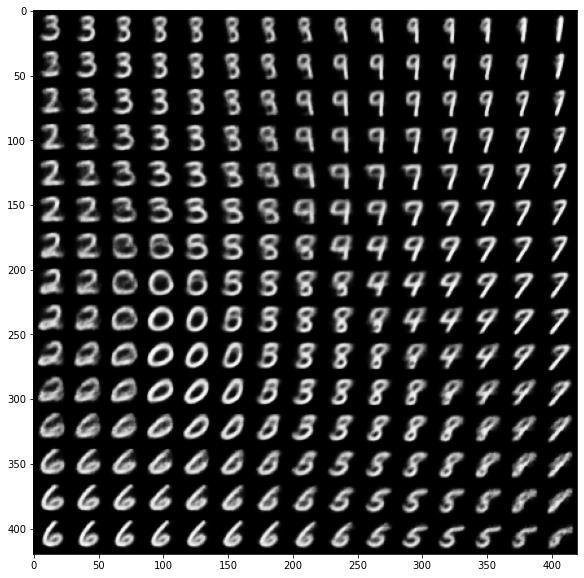

In [19]:
import matplotlib.pyplot as plt
from scipy.stats import norm

# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# Linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z,
# since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()